In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import PowerTransformer,StandardScaler,RobustScaler,OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

df = pd.read_csv("project_dataset.csv") 

df = df.drop(columns=[
    'customer_id',
    'sin_age',
    'signup_dayofweek',
    'signup_date',
    'region'
])

df['education'] = df['education'].replace({
    'Bachlors': 'Bachelors',
    'HS': 'High School'
})

TARGET = 'target_default_risk'

X = df.drop(columns=[TARGET])
y = df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

num_cols = ['income', 'loan_amount', 'savings', 'monthly_expenses']
cat_cols = ['education','marital_status']
other_num_cols = ['age', 'num_dependents', 'credit_score','loan_term_months', 
                  'employment_years','debt_to_income']
edu_col=['education']
education_order = ['Other','High School','Bachelors','Masters','PhD']


num_power = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('yeo_johnson', PowerTransformer(method='yeo-johnson', standardize=False)),
    ('scaler', RobustScaler())
])


num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

edu_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=[education_order], handle_unknown='use_encoded_value', unknown_value=-1))
])

main_col = ColumnTransformer([
    ('num', num_power, num_cols),
    ('other_num_cols', num_pipe, other_num_cols),
    ('edu', edu_pipe, edu_col),
    ('cat', cat_pipe, cat_cols)
], remainder='drop')

gb_clf = GradientBoostingClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

stage1_pipeline = Pipeline([
    ('preprocessing', main_col),
    ('model', gb_clf)
])


stage1_pipeline.fit(X_train, y_train)

X_train_trans = stage1_pipeline.named_steps['preprocessing'].transform(X_train)
X_test_trans  = stage1_pipeline.named_steps['preprocessing'].transform(X_test)

feature_names = stage1_pipeline.named_steps['preprocessing'].get_feature_names_out()
X_train_stage2 = pd.DataFrame(X_train_trans, columns=feature_names, index=X_train.index)
X_test_stage2  = pd.DataFrame(X_test_trans, columns=feature_names, index=X_test.index)

X_train_stage2['gb_prob'] = stage1_pipeline.predict_proba(X_train)[:, 1]
X_test_stage2['gb_prob']  = stage1_pipeline.predict_proba(X_test)[:, 1]


def evaluate_stage2_models(X, y):

    models = {
        "Logistic Regression": LogisticRegression(
            max_iter=1000,
            class_weight='balanced'
        ),
        "Decision Tree": DecisionTreeClassifier(
            max_depth=6,
            min_samples_split=20,
            random_state=42
        ),
        "Random Forest": RandomForestClassifier(
            n_estimators=400,
            max_depth=8,
            min_samples_split=15,
            n_jobs=-1,
            random_state=42
        ),
        "SVC": SVC(
            kernel='rbf',
            C=1.5,
            probability=True,
            class_weight='balanced'
        ),
        "XGBoost": XGBClassifier(
            n_estimators=900,
            max_depth=3,
            learning_rate=0.04,
            subsample=0.85,
            colsample_bytree=0.85,
            reg_alpha=0.3,
            reg_lambda=1.2,
            gamma=0.1,
            random_state=42,
            eval_metric='logloss'
        )
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for name, model in models.items():
        scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
        print(name, "Accuracy:", scores.mean())

evaluate_stage2_models(X_train_stage2, y_train)



Logistic Regression Accuracy: 0.9616250000000001
Decision Tree Accuracy: 0.957625
Random Forest Accuracy: 0.961125
SVC Accuracy: 0.9565000000000001
XGBoost Accuracy: 0.9650000000000001


C:\Users\Sourav\AppData\Local\Temp\ipykernel_3808\222612450.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='Set2')


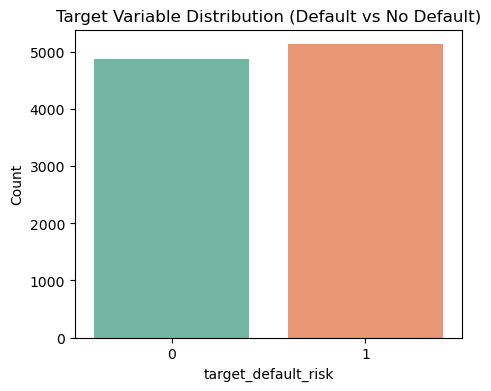

In [8]:
plt.figure(figsize=(5,4))
sns.countplot(x=y, palette='Set2')
plt.title("Target Variable Distribution (Default vs No Default)")
plt.xlabel("target_default_risk")
plt.ylabel("Count")
plt.show()


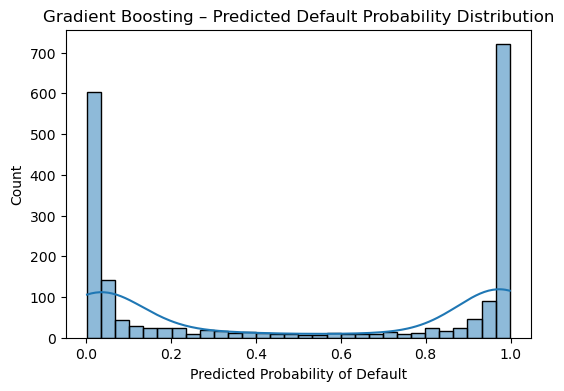

In [9]:
gb_probs = stage1_pipeline.predict_proba(X_test)[:, 1]

plt.figure(figsize=(6,4))
sns.histplot(gb_probs, bins=30, kde=True)
plt.title("Gradient Boosting – Predicted Default Probability Distribution")
plt.xlabel("Predicted Probability of Default")
plt.show()


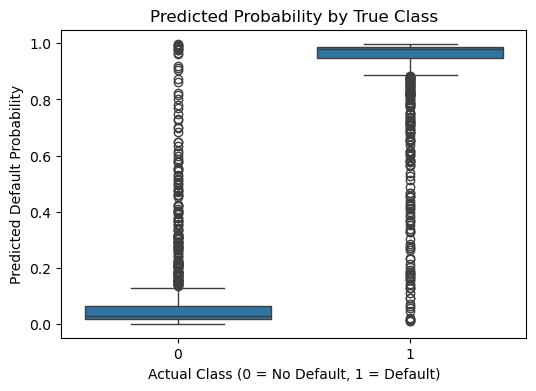

In [10]:
prob_df = pd.DataFrame({
    'probability': gb_probs,
    'actual': y_test.values
})

plt.figure(figsize=(6,4))
sns.boxplot(x='actual', y='probability', data=prob_df)
plt.title("Predicted Probability by True Class")
plt.xlabel("Actual Class (0 = No Default, 1 = Default)")
plt.ylabel("Predicted Default Probability")
plt.show()


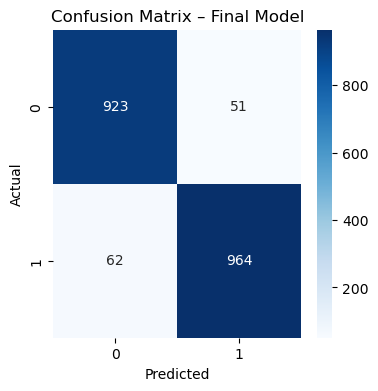

In [11]:
final_model = XGBClassifier(
    n_estimators=900,
    max_depth=3,
    learning_rate=0.04,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_alpha=0.3,
    reg_lambda=1.2,
    gamma=0.1,
    random_state=42,
    eval_metric='logloss'
)

final_model.fit(X_train_stage2, y_train)
y_pred = final_model.predict(X_test_stage2)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Final Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


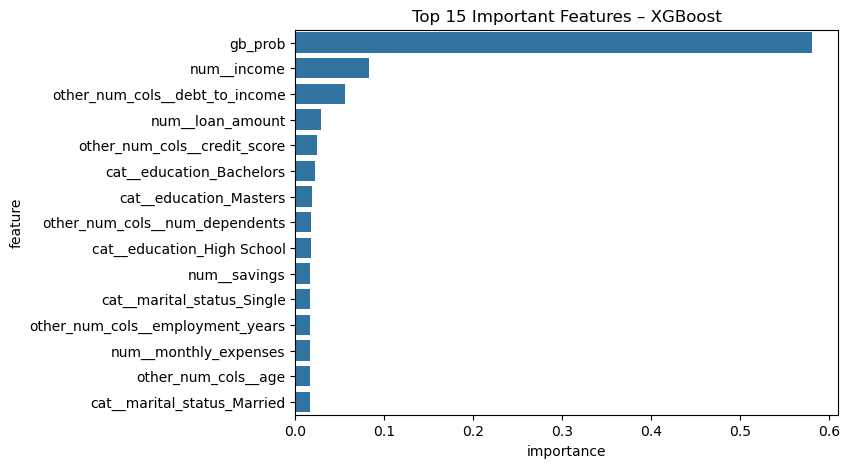

In [12]:
importances = final_model.feature_importances_
features = X_train_stage2.columns

imp_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False).head(15)

plt.figure(figsize=(7,5))
sns.barplot(x='importance', y='feature', data=imp_df)
plt.title("Top 15 Important Features – XGBoost")
plt.show()


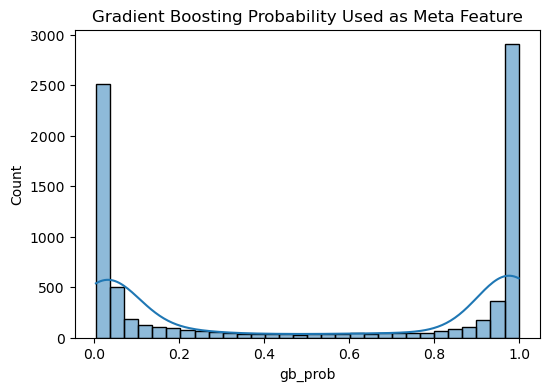

In [13]:
plt.figure(figsize=(6,4))
sns.histplot(X_train_stage2['gb_prob'], bins=30, kde=True)
plt.title("Gradient Boosting Probability Used as Meta Feature")
plt.xlabel("gb_prob")
plt.show()



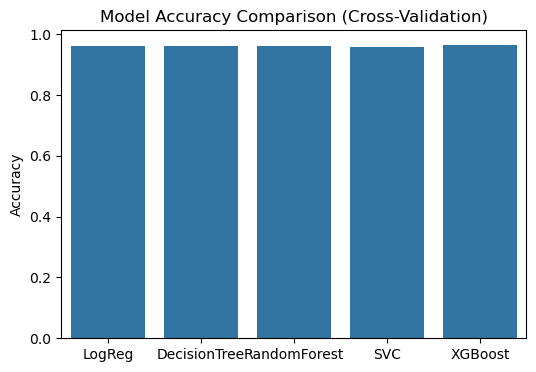

In [14]:
models = ['LogReg', 'DecisionTree', 'RandomForest', 'SVC', 'XGBoost']
accuracies = []

for name, model in [
    ('LogReg', LogisticRegression(max_iter=1000, class_weight='balanced')),
    ('DecisionTree', DecisionTreeClassifier(max_depth=6, min_samples_split=20)),
    ('RandomForest', RandomForestClassifier(n_estimators=400, max_depth=8)),
    ('SVC', SVC(kernel='rbf', C=1.5)),
    ('XGBoost', XGBClassifier(eval_metric='logloss'))
]:
    scores = cross_val_score(model, X_train_stage2, y_train,
                             cv=5, scoring='accuracy')
    accuracies.append(scores.mean())

plt.figure(figsize=(6,4))
sns.barplot(x=models, y=accuracies)
plt.title("Model Accuracy Comparison (Cross-Validation)")
plt.ylabel("Accuracy")
plt.show()


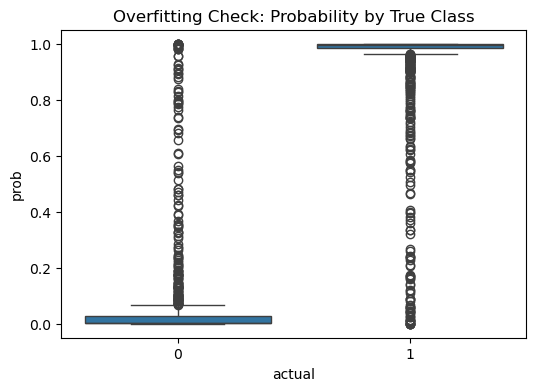

In [15]:
probs = final_model.predict_proba(X_test_stage2)[:, 1]

df_prob = pd.DataFrame({
    'prob': probs,
    'actual': y_test.values
})

plt.figure(figsize=(6,4))
sns.boxplot(x='actual', y='prob', data=df_prob)
plt.title("Overfitting Check: Probability by True Class")
plt.show()
